In [347]:
import pandas as pd
import numpy as np
import sklearn
import spacy
import nltk
import re
from collections import Counter
import torch
import statsmodels as sm
import seaborn as sns
import matplotlib.pyplot as plt
import faiss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sentence_transformers import SentenceTransformer
import warnings

warnings.filterwarnings("ignore")
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\talbd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [329]:
def preprocess_corpus(text):
    """
    Before tokenization, normalize the text:

        - Remove extra whitespace and line breaks.
        - Convert text to lowercase (for case insensitivity).
        - Remove non-alphanumeric characters (punctuation, special symbols).
        - Normalize quotes and dashes.
    :return: processed text
    """
    text = clean_text(text)
    sentences = nltk.sent_tokenize(text)
    passages = [" ".join(sentences[i:i + 5]) for i in range(0, len(sentences), 5)]
    print(len(passages))
    passages = [lemmatize(p) for p in passages]
    return passages


def clean_text(text):
    """
    Before tokenization, normalize the text:

        - Remove extra whitespace and line breaks.
        - Convert text to lowercase (for case insensitivity).
        - Remove non-alphanumeric characters (punctuation, special symbols).
        - Normalize quotes and dashes.
    :param text: text to process
    :return: processed text
    """
    # text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces and newlines
    # text = re.sub(r'[“”‘’]', '"', text)  # Normalize quotes
    text = re.sub(r'[-—]', ' ', text)  # Normalize dashes
    # text = re.sub(r'[^a-z0-9\s]', '', text)  # Remove special characters
    return text


def lemmatize(text):
    """

    :param text:
    :return:
    """
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop])


def create_chunks(text):
    """

    :param text:
    :return:
    """
    sentences = nltk.sent_tokenize(text)
    passage_size = 5
    passages = [" ".join(sentences[i:i + passage_size]) for i in range(0, len(sentences), passage_size)]
    return passages

In [3]:
def load_data(dir_path="data", file_name="corcerers_stone_harry_poter1", file_fmt="txt"):
    file_path = f"{dir_path}/{file_name}.{file_fmt}"
    with open(file_path, "r", encoding="utf-8") as f:
        book_text = f.read()
    return book_text

In [137]:
book_text = load_data()

In [11]:
doc = nlp(book_text[:100])
print([(w.text, w.pos_) for w in doc])

[('Harry', 'PROPN'), ('Potter', 'PROPN'), ('and', 'CCONJ'), ('the', 'DET'), ('Sorcerer', 'PROPN'), ("'s", 'PART'), ('Stone', 'PROPN'), ('\n\n\n', 'SPACE'), ('CHAPTER', 'NOUN'), ('ONE', 'NUM'), ('\n\n', 'SPACE'), ('THE', 'DET'), ('BOY', 'NOUN'), ('WHO', 'PRON'), ('LIVED', 'VERB'), ('\n\n', 'SPACE'), ('Mr.', 'PROPN'), ('and', 'CCONJ'), ('Mrs.', 'PROPN'), ('Dursley', 'PROPN'), (',', 'PUNCT'), ('of', 'ADP'), ('num', 'NUM')]


In [158]:
# Regular expression pattern for "CHAPTER {NUMBER_IN_WORDS}\n\n{TITLE}\n\n"
chapter_pattern = r'\n\n\nCHAPTER\s+([A-Z]+)\n\n([A-Z\s]+)\n\n'
idx_title_tups = re.findall(chapter_pattern, book_text)
chapters_titles = [m[1].strip() for m in idx_title_tups]

chapter_pattern = r'\n\n\nCHAPTER\s+([A-Z]+)\n\n'
chapters_idx_list = [f"CHAPTER {idx}" for idx in re.findall(chapter_pattern, book_text)]
[txt.split(i) for i in chapters_idx_list]
split_patterns = [f"{c_idx}\n\n{c_title}\n\n" for c_idx, c_title in zip(chapters_idx_list, chapters_titles)]
chapters_idx_list

['CHAPTER ONE',
 'CHAPTER TWO',
 'CHAPTER THREE',
 'CHAPTER FOUR',
 'CHAPTER FIVE',
 'CHAPTER SIX',
 'CHAPTER SEVEN',
 'CHAPTER EIGHT',
 'CHAPTER NINE',
 'CHAPTER TEN',
 'CHAPTER ELEVEN',
 'CHAPTER TWELVE',
 'CHAPTER THIRTEEN',
 'CHAPTER FOURTEEN',
 'CHAPTER FIFTEEN',
 'CHAPTER SIXTEEN',
 'CHAPTER SEVENTEEN']

In [212]:
def clean_newlines(text):
    text = re.sub(r'(?<!\n)\n(?!\n)', ' ', text)
    return text

In [257]:
store_csv = False

book_text = load_data()
chapter_pattern = r'(CHAPTER\s+[A-Z]+)\n\n([A-Z\s\-]+)\n\n'
sections = re.split(chapter_pattern, book_text)
book_heading, book_content = sections[0], sections[1:]

str_idx = book_content[0::3]
chapters_titles = book_content[1::3]
chapters_texts = book_content[2::3]
chapter_idx = range(1, len(str_idx) + 1)

book_df = pd.DataFrame.from_records(zip(chapter_idx, str_idx, chapters_titles, chapters_texts),
                                    columns=['chapter_idx', 'str_idx', 'title', 'raw_content'])

book_df['processed_content'] = book_df['raw_content'].apply(lambda chapter_content: clean_newlines(chapter_content))
if store_csv:
    book_df.to_csv('data/book_df.csv', index=False)

In [344]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 3), max_features=500,stop_words='english')
X = vectorizer.fit_transform(book_df['processed_content'])
vectorizer.get_feature_names_out()

array(['able', 'afternoon', 'ahead', 'air', 'allowed', 'answer', 'arm',
       'arms', 'arrived', 'ask', 'asked', 'asleep', 'aunt',
       'aunt petunia', 'away', 'bad', 'bane', 'bed', 'began', 'believe',
       'best', 'bet', 'better', 'big', 'bit', 'black', 'blood', 'body',
       'book', 'books', 'boy', 'boys', 'break', 'bright', 'broom',
       'broomstick', 'brought', 'called', 'came', 'car', 'castle', 'cat',
       'catch', 'caught', 'cauldron', 'ceiling', 'charlie', 'chocolate',
       'christmas', 'class', 'cloak', 'clock', 'close', 'cold', 'come',
       'coming', 'common', 'common room', 'corner', 'corridor', 'couldn',
       'course', 'crabbe', 'crabbe goyle', 'crowd', 'cup', 'cupboard',
       'dad', 'dark', 'day', 'dead', 'dear', 'deep', 'did', 'didn',
       'didn know', 'died', 'different', 'disappeared', 'does', 'dog',
       'doing', 'don', 'don know', 'don want', 'door', 'dragon', 'drive',
       'dropped', 'dudley', 'dumbledore', 'dursley', 'dursleys', 'end',
       

In [345]:
book_df = pd.read_csv('data/book_df.csv')
example_chapter = book_df['processed_content'].iloc[0]
doc = nlp(example_chapter)

In [346]:
for i,c in enumerate(book_df['processed_content'].to_list()):
    c = clean_text(c)
    doc = nlp(c)
    print("================================================================================")
    print(book_df['str_idx'].iloc[i])
    print("Persons:", set([entity.text for entity in doc.ents if entity.label_ == 'PERSON']))
    print("ORGs:", set([entity.text for entity in doc.ents if entity.label_ == 'ORG']))
    print("PRODUCTs:", set([entity.text for entity in doc.ents if entity.label_ == 'PRODUCT']))
    print("FACs:", set([entity.text for entity in doc.ents if entity.label_ == 'FAC']))

CHAPTER ONE
Persons: {'baker', 'Next Door', 'James', 'Dumbledore calmly', 'Dursleys', 'Albus Dumbledore', 'Dudley', 'Harry', 'Harry Potter', 'Lily', 'Potter', 'McGonagall', 'Harry Potter    ', 'Harold', 'Put Outer', 'Godric', 'Dedalus Diggle', 'Dursley', 'Harry    ', 'moon spectacles', 'Jim McGuffin', 'Potters', 'Jim', 'Howard', 'Dumbledore', 'James Potter', 'YouKnow'}
ORGs: {'Harry', 'Dundee', 'Bristol', 'Dumbledore', 'Potters', 'Hagrid', 'Kent', 'Grunnings', 'Voldemort', 'Albus Dumbledore'}
PRODUCTs: {'Dumbledore', 'Hagrid'}
FACs: {'Madam Pomfrey', 'the London Underground', 'Privet Drive', 'Kent    '}
CHAPTER TWO
Persons: {'Figg', 'Tufty', 'Snowy', 'Dursleys', 'Dudley', 'Harry Potter', 'Harry', 'Uncle Vernon', "Uncle Vernon's", 'Dursley', 'Paws', 'Boa Constrictor', 'Mummy', 'Dudley Dursley', 'Mommy', 'Duddy', 'jabbed', 'Marge', 'Aunt Petunia', 'Piers and Dudley'}
ORGs: {'Dinky Duddydums', 'Harry', 'Atta', 'Piers', 'Piers Polkiss', 'boa', 'Vernon', "Auntie Marge's", 'Uncle Vernon', 'A

In [233]:
def tokenize(chapter):
    sent_tokenize(chapter)

['Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much.',
 "They were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense.",
 'Mr. Dursley was the director of a firm called Grunnings, which made drills.',
 'He was a big, beefy man with hardly any neck, although he did have a very large mustache.',
 'Mrs. Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors.',
 'The Dursleys had a small son called Dudley and in their opinion there was no finer boy anywhere.',
 'The Dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it.',
 "They didn't think they could bear it if anyone found out about the Potters.",
 "Mrs. Potter was Mrs. Dursley's sister, but

## Analysis

In [266]:
passage_idx = []

for i, chapter_passages in enumerate(book_df['processed_content'].str.split('\n\n').to_list(), 1):
    for j, single_passage in enumerate(chapter_passages):
        passage_idx.append((i, j, single_passage))
passages_df = pd.DataFrame.from_records(passage_idx, columns=['chapter_idx', 'passage_idx', 'content'])

In [267]:
passages_df = pd.merge(left=passages_df, how='left', right=book_df[['str_idx', 'chapter_idx']], right_on='chapter_idx',
                       left_on='chapter_idx')
passages_df[['str_idx', 'chapter_idx', 'passage_idx', 'content']]

,str_idx,chapter_idx,passage_idx,content
0,CHAPTER ONE,1,0,"Mr. and Mrs. Dursley, of number four, Privet D..."
1,CHAPTER ONE,1,1,Mr. Dursley was the director of a firm called ...
2,CHAPTER ONE,1,2,"The Dursleys had everything they wanted, but t..."
3,CHAPTER ONE,1,3,"When Mr. and Mrs. Dursley woke up on the dull,..."
4,CHAPTER ONE,1,4,"None of them noticed a large, tawny owl flutte..."
...,...,...,...,...
3008,CHAPTER SEVENTEEN,17,216,Harry hung back for a last word with Ron and H...
3009,CHAPTER SEVENTEEN,17,217,"""See you over the summer, then."""
3010,CHAPTER SEVENTEEN,17,218,"""Hope you have -- er -- a good holiday,"" said ..."
3011,CHAPTER SEVENTEEN,17,219,"""Oh, I will,"" said Harry, and they were surpri..."


In [279]:
query = ["How does Harry find out he is a wizard?", "How was Harry's last month with the Dursleys?"][1:]

vectorizer = TfidfVectorizer(stop_words="english")  #, max_df=0.9, min_df=2)
tfidf_matrix = vectorizer.fit_transform(book_df['processed_content'])
query_vector = vectorizer.transform(query)

similarity_scores = cosine_similarity(query_vector, tfidf_matrix)

ranked_indices = np.argsort(similarity_scores[0])[::-1]
print(ranked_indices)
print("Top 5 Relevant Passages:")
for i in range(5):
    idx = ranked_indices[i]
    print(f"\nRank {i + 1}, Score: {similarity_scores[0][idx]:.4f}")
    print(book_df.iloc[idx, [0, 1, 2]])
    print(book_df['processed_content'].iloc[-1])

[ 1  5  4 11 16 15  9 10 14  7 12  6  2  8  3 13  0]
Top 5 Relevant Passages:

Rank 1, Score: 0.1859
chapter_idx                      2
str_idx                CHAPTER TWO
title          THE VANISHING GLASS
Name: 1, dtype: object
It was Quirrell.

"You!" gasped Harry.

Quirrell smiled. His face wasn't twitching at all.

"Me," he said calmly. "I wondered whether I'd be meeting you here, Potter."

"But I thought -- Snape --"

"Severus?" Quirrell laughed, and it wasn't his usual quivering treble, either, but cold and sharp. "Yes, Severus does seem the type, doesn't he? So useful to have him swooping around like an overgrown bat. Next to him, who would suspect p-p-poor, st-stuttering P-Professor Quirrell?"

Harry couldn't take it in. This couldn't be true, it couldn't.

"But Snape tried to kill me!"

"No, no, no. I tried to kill you. Your friend Miss Granger accidentally knocked me over as she rushed to set fire to Snape at that Quidditch match. She broke my eye contact with you. Another fe

In [ ]:
chapters = book_df['processed_content'].tolist()


def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text) 
    text = " ".join([word for word in text.split() if word not in stopwords.words('english')])
    return text


def get_top_words(model, feature_names, n_top_words=5):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(", ".join(top_words))
    return topics

processed_chapters = [preprocess_text(chapter) for chapter in chapters]
chapter_topics = []
for i, pc in enumerate(processed_chapters):
    vectorizer = CountVectorizer(max_features=5000,ngram_range=(1,2)) 
    doc_term_matrix = vectorizer.fit_transform([pc])

    lda_model = LatentDirichletAllocation(n_components=5, random_state=42)  # Extract 5 topics per chapter
    lda_model.fit(doc_term_matrix)
    feature_names = vectorizer.get_feature_names_out()
    top5 = get_top_words(lda_model, feature_names)
    print(book_df['title'].iloc[i])
    print(top5)
    chapter_topics.append(top5)
    print()

chapter_topics

# MINI LM

In [282]:
def embedding_model():
    EMBEDDING_MODEL = 'all-MiniLM-L6-v2'
    model = SentenceTransformer(EMBEDDING_MODEL)
    return model

In [289]:
def embedd_dataset(dataset,
                   split: str = 'train',
                   model: SentenceTransformer = SentenceTransformer('all-MiniLM-L6-v2'),
                   text_field: str = 'content',
                   rec_num: int = -1) -> tuple:
    """
    Load a dataset and embedd the text field using a sentence-transformer model
    :param dataset: The name of the dataset to load
    :param split: The split of the dataset to load
    :param model: The model to use for embedding
    :param text_field: The field in the dataset that contains the text
    :param rec_num: The number of records to load and embedd
    :return: tuple: A tuple containing the dataset and the embeddings
    """

    embeddings = model.encode(dataset[text_field][:rec_num])
    print("Done!")
    return dataset, embeddings

## Faiss index

In [296]:
def build_faiss_flatl2_index(
        index_vectors: np.ndarray,
        dim: int,
):
    """
    This function builds a Faiss flat L2 index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
    Returns:
        A Faiss flat L2 index.
    """
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings)
    return index

def build_faiss_lsh_index(
        index_vectors: np.ndarray,
        dim: int,
        nbits: int,
):
    """
    This function builds a Faiss LSH index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
        nbits: The number of bits to use in the hash.
    Returns:
        A Faiss LSH index.
    """
    index = faiss.IndexLSH(dim, nbits)
    index.add(index_vectors)
    return index

def train_index(index, sentence_embeddings: np.ndarray):
    index.add(sentence_embeddings)

def encode_query(query: str):
    q_embd = model.encode(query)
    return q_embd


def compute_recall_at_k(
        nn_gt: np.ndarray,
        ann: np.ndarray,
        k: int,
):
    """
    This function computes the recall@k.
    Args:
        nn_gt: The ground truth nearest neighbors.
        ann: The approximate nearest neighbors.
        k: The number of nearest neighbors to consider.
    Returns:
        The recall@k.
    """
    return round(sum([len(set(ann[i]) & set(nn_gt[i])) / k for i in range(len(ann))])/len(ann), 3)

In [290]:
model = embedding_model()
dataset, embeddings = embedd_dataset(
    dataset=passages_df,
    rec_num=-1,
    model=model,
)
embeddings_shape = embeddings.shape

Done!


In [313]:
from sklearn.cluster import AgglomerativeClustering

sentences = passages_df.content.to_list()
# Define number of clusters (adjust dynamically based on the chapter length)
num_clusters = len(sentences) // 7  # Roughly one cluster per 5 sentences


clustering_model = AgglomerativeClustering(n_clusters=num_clusters,metric='cosine', linkage='average')
cluster_labels = clustering_model.fit_predict(embeddings)


sentence_clusters = list(zip(sentences, cluster_labels))
cluster_dict = defaultdict(list)
for sentence, cluster in sentence_clusters:
    cluster_dict[cluster].append(sentence)


content_chunks = [" ".join(cluster_dict[cluster]) for cluster in sorted(cluster_dict.keys())]

print(f"Generated {len(content_chunks)} content-based chunks.")

Generated 430 content-based chunks.


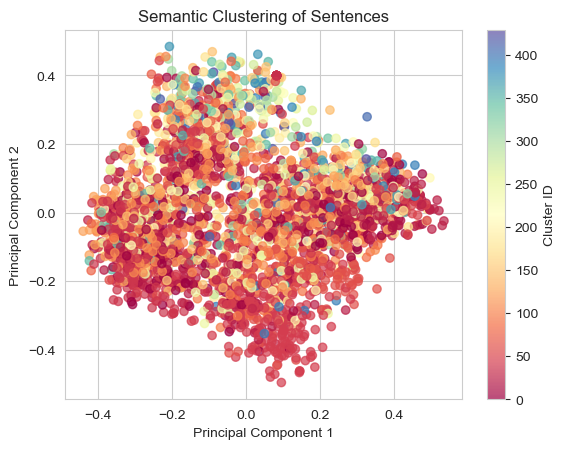

In [318]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='Spectral', alpha=0.7)
plt.title("Semantic Clustering of Sentences")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster ID")
plt.show()

In [301]:
index = build_faiss_flatl2_index(embeddings,embeddings_shape)

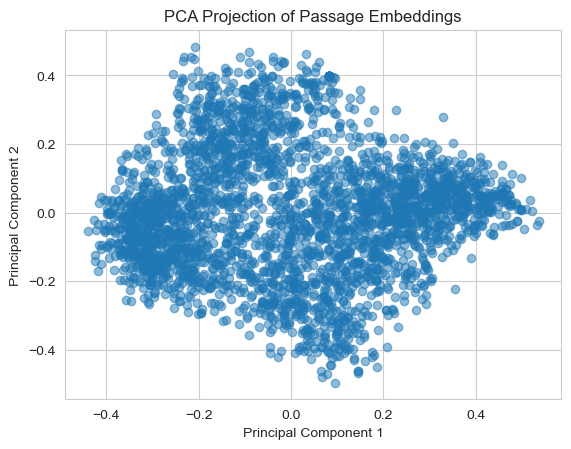

In [298]:

# Reduce dimensionality of embeddings to visualize in 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plot the 2D projection of vectors
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.5)
plt.title("PCA Projection of Passage Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


##### We can observe a well-distributed spread of points, indicating a good semantic separation. We can see 4 clusters, which inddicate similar thematic content in the text.

In [348]:
def retrieve_top_passages(query, model, index, chunks, top_n=5):
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, top_n) 
    results = [(chunks[idx], distances[0][i]) for i, idx in enumerate(indices[0])]
    return results

# Define queries
queries = [
    "What is Hogwarts?",
    "Who is Harry Potter?",
    "How does magic work?"
]


retrieval_results = {query: retrieve_top_passages(query, model, index, chunks) for query in queries}

retrieval_data = []
for query, passages in retrieval_results.items():
    for rank, (text, score) in enumerate(passages):
        retrieval_data.append({"Query": query, "Rank": rank + 1, "Score": score, "Passage": text[:200] + "..."})  

retrieval_df = pd.DataFrame(retrieval_data)
retrieval_df

NameError: name 'chunks' is not defined